# __Compte rendu BE AML__

Authors : Tom BOISSE & Jules ESPINOUX

## __Description des données__

Le jeu de données "Gungor 2018 Victorian Author Attribution" est un fichier CSV à deux colonnes :<br>
- La première comprend des extraits de 1000 mots d’auteurs anglais du 19ème siècle (ayant écrit au moins 5 livres). Les 500 mots les plus et moins fréquents, les noms de livres et certains termes spécifiques ont été retirés. Après sélection des 10 000 mots les plus courants et adaptation des phrases en conservant la syntaxe, on obtient plus de 53 000 lignes de 1000 mots, normalisées et sans ponctuation.<br>
- La deuxième colonne contient l’identifiant de l’auteur, numéro de 1 à 50.<br>
Dans la suite, une "phrase" désigne une ligne de 1000 mots ; "corpus" désigne l’ensemble des phrases. 

## __Objectifs et plan d'action__

L'objectif de ce corpus est d'être capable de prédire quel auteur a écrit une phrase que l'on donnerait en entrée.<br>
Nous avons remarqué que nos données d'entraînement sont standardisées donc nous n'avons pas de prétraitement à faire. Notre problème est une classification supervisée à 50 classes. Ce problème simple en apparence a ici une grande complexité liée à la forme des entrées. En effet, le texte est une entrée compliquée à gérer car il y a des notions de relations entre chaque mot dans la phrase. Ceci s'explique grâce aux différentes règles de grammaire et de conjugaison. Si nous voulons obtenir le maximum de précision, il faudra chercher un moyen de transformer nos textes en entrées valides pour des classifieurs tout en essayant de garder ces éléments de relations. <br>
 
### Transformation des entrées

Cette étape est cruciale pour la suite, nous avons deux pistes que nous aimerions tester. La première est le Bag of Words (BoW) et la seconde est le TF-IDF. Ces deux pistes sont connues sous le nom de vectorizers car elles transforment une phrase qui est une liste de mots en un vecteur de nombres plus digeste pour des algorithmes de machine learning. <br>
L'idée de la première est de prendre l'entièreté du corpus, de trier chaque mot par rapport à sa fréquence d'apparition pour ensuite transformer chaque phrase en vecteur de taille 10 000 (nombre de mots différents dans notre corpus) où la donnée à l'indice i représente le nombre d'occurrences dans notre phrase du ième mot le plus récurrent dans notre corpus. Ainsi, si "the" est le 4ème le plus courant dans tout notre corpus et que dans notre phrase il apparaît 5 fois, alors après transformation de notre phrase, à l'indice 4 nous retrouverons le nombre 5.
<br>
La seconde piste est un acronyme pour Term Frequency - Inverse Document Frequency. Nous précalculons l'IDF qui est un vecteur représentant, pour chaque mot, l'inverse de sa fréquence d'apparition dans tout le corpus. Et pour chaque phrase, quand nous voulons la transformer, nous calculons sa TF qui est la fréquence d'apparition du mot dans cette phrase. Ainsi, si nous avons "cat cat dog" et que cat apparaît 5 fois dans tout le corpus et dog 9 fois, quand nous transformerons la phrase, nous obtiendrons [2/5, 2/5, 1/9]. 

#### Classification des données
 
Nous devons essayer de trouver une méthode qui a un bon potentiel pour apprendre à classer chaque phrase grâce à son label avec plus de 2 classes. Deux algorithmes sortent du lot pour cette tâche précise, ce sont le Naïve Bayes et le SVM. Dans un premier temps, nous allons tester ces algorithmes avec un split de notre jeu de données pour estimer le potentiel de chaque méthode, puis ensuite nous essaierons d'affiner les hyperparamètres pour améliorer la précision de notre modèle.

## __Transformation de nos données__

Nous allons donc appliquer ce que nous avons définit plus tôt. Nous faisons le choix d'entraîner nos deux vectorizers sur notre corpus et pas juste sur le sous ensemble d'entraînement car ceci améliore la précision des vectorizers sans impacter la transformation des données.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

In [3]:
# loading the csv file, separate data and labels and then split
df_train = pd.read_csv("dataset/Gungor_2018_VictorianAuthorAttribution_data-train.csv", sep=",", encoding='latin-1')
X_total = df_train["text"].values
y_total = df_train["author"].values
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer # bow vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf vectorizer

In [4]:
# creating bow vectorizer + train with total data set
bow_vectorizer = CountVectorizer()
bow_vectorizer.fit(X_total)

CountVectorizer()

In [5]:
X_train_bow = bow_vectorizer.transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [5]:
# creating tf idf vectorizer + train with total data set
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_total)

TfidfVectorizer()

In [6]:
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## __Classification des données__

Nous allons donc essayer nos 4 combinaisons. Nos deux vectorizers avec Naïve Bayes et nos deux vectorizers avec SVM.

In [7]:
from sklearn.naive_bayes import MultinomialNB # naives bayes classifier
from sklearn.svm import LinearSVC # svm classifier
from sklearn.metrics import accuracy_score # compute accuracy scores

### Naive Bayes 

In [9]:
nb_model = MultinomialNB() # naive bayes model
nb_model.fit(X_train_bow, y_train)
y_nb_bow = nb_model.predict(X_test_bow)
print(f"*-* Accuracy for BoW and Naive Bayes :  {accuracy_score(y_test, y_nb_bow):.3f}")

*-* Accuracy for BoW and Naive Bayes :  0.864


In [10]:
nb_model = MultinomialNB() # naive bayes model
nb_model.fit(X_train_tfidf, y_train)
y_nb_tfidf = nb_model.predict(X_test_tfidf)
print(f"*-* Accuracy for TFIDF and Naive Bayes :  {accuracy_score(y_test, y_nb_tfidf):.3f}")

*-* Accuracy for TFIDF and Naive Bayes :  0.508


### SVM

In [11]:
svm_model = LinearSVC(C=1) # svm model
svm_model.fit(X_train_bow, y_train)
y_svm_bow = svm_model.predict(X_test_bow)
print(f"*-* Accuracy for BoW and SVM :  {accuracy_score(y_test, y_svm_bow):.3f}")

*-* Accuracy for BoW and SVM :  0.978


In [12]:
svm_model = LinearSVC(C=1) # svm model
svm_model.fit(X_train_tfidf, y_train)
y_svm_tfidf = svm_model.predict(X_test_tfidf)
print(f"*-* Accuracy for TFIDF and SVM :  {accuracy_score(y_test, y_svm_tfidf):.3f}")

*-* Accuracy for TFIDF and SVM :  0.979


## __Affinement du modèle__

Après une première série de test, nous notons que comme attendus Naive Bayes est bien plus rapide que SVM et nous conjecturons que BoW fonctionne mieux avec Naive Bayes et que TF-IDF fonctionne mieux avec SVM. Nous allons essayer d'affiner ces deux paires de modèles pour ne garder que le plus performant.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [13]:
param_grid_nb = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, 
                              scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_nb.fit(X_train_bow, y_train)

alpha_values = [params['alpha'] for params in grid_search_nb.cv_results_['params']]
mean_scores_nb = grid_search_nb.cv_results_['mean_test_score']
std_scores_nb = grid_search_nb.cv_results_['std_test_score']

print(f"*-* Optimal alpha: {grid_search_nb.best_params_['alpha']}")
print(f"*-* CV accuracy: {grid_search_nb.best_score_:.4f}")
print(f"*-* Test accuracy: {grid_search_nb.score(X_test_bow, y_test):.4f}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Optimal alpha: 0.1
CV accuracy: 0.8678
Test accuracy: 0.8705


Après notre premier passage, il semble de que la valeur de l'hyperparamètre se trouve autour de 0.1. Essayons d'affiner.

In [15]:
param_grid_nb = {'alpha': [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]}
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, 
                              scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_nb.fit(X_train_bow, y_train)

alpha_values = [params['alpha'] for params in grid_search_nb.cv_results_['params']]
mean_scores_nb = grid_search_nb.cv_results_['mean_test_score']
std_scores_nb = grid_search_nb.cv_results_['std_test_score']

print(f"*-* Optimal alpha: {grid_search_nb.best_params_['alpha']}")
print(f"*-* CV accuracy: {grid_search_nb.best_score_:.4f}")
print(f"*-* Test accuracy: {grid_search_nb.score(X_test_bow, y_test):.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Optimal alpha: 0.06
CV accuracy: 0.8682
Test accuracy: 0.8701


Après un deuxième passage, nous avons augmenter notre précision de 0.04%. Nous allons nous arrêter là pour Naive Bayes.

In [16]:
param_grid = {'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10]}
grid_search = GridSearchCV(LinearSVC(max_iter=10000), param_grid, cv=5, 
                           scoring='accuracy', n_jobs=-1, verbose=1)

# Fit and find best C
grid_search.fit(X_train_tfidf, y_train)

# Extract results
C_values = [params['C'] for params in grid_search.cv_results_['params']]
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']

print(f"*-* Optimal C: {grid_search.best_params_['C']}")
print(f"*-* CV accuracy: {grid_search.best_score_:.4f}")
print(f"*-* Test accuracy: {grid_search.score(X_test_tfidf, y_test):.4f}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Optimal C: 10
CV accuracy: 0.9828
Test accuracy: 0.9830


On voit que le paramètre C optimal vaut 10 et qu'on a une précision améliorée à plus de 98%. Le modèle est très performant. 
On pourrait chercher à affiner encore plus le modèle sauf que le temps d'éxécution élevé et qu'on risque de tendre vers de l'overfitting, on choisit donc de rester avec ce modèle qui nous convient très largement.

## __Interprétabilité du modèle SVM__


On considère par la suite que le modèle SVM optimal, soit avec C=5 comme trouvé précédemment. Le SVM est réputé pour être difficilement interprétable, on va chercher à extraire des informations à partir des résultats du modèle.

In [8]:
best_svm = LinearSVC(C=10, max_iter=10000)
best_svm.fit(X_train_tfidf, y_train)
feature_names = tfidf_vectorizer.get_feature_names_out()

### 1. Top mots discriminants par auteur


Visualisation des poids SVM les plus discriminants (en valeur absolue) pour 3 auteurs. Les poids positifs (vert) favorisent la classification vers l'auteur, les négatifs (rouge) discriminent contre.


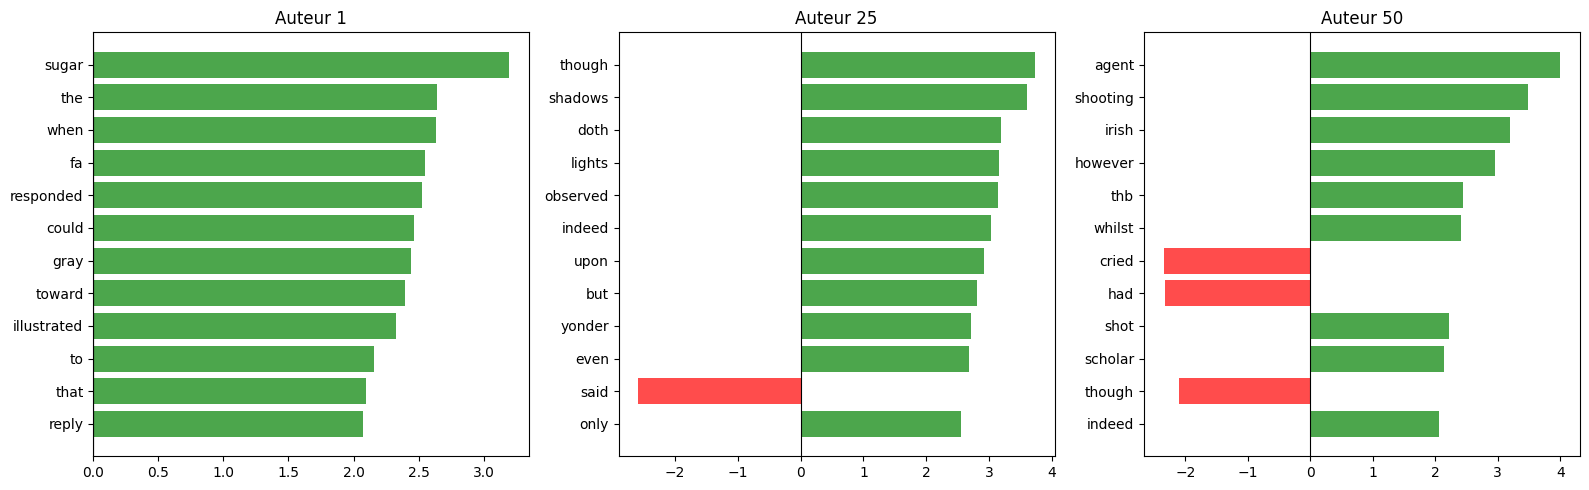

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
classes_in_train = np.unique(y_train)
selected_idx = [0, len(classes_in_train)//2, -1]

for i, idx in enumerate(selected_idx):
    author = classes_in_train[idx]
    coefs = best_svm.coef_[idx]
    top_idx = np.argsort(np.abs(coefs))[-12:][::-1]
    
    words = [feature_names[j] for j in top_idx]
    weights = [coefs[j] for j in top_idx]
    colors = ['green' if w > 0 else 'red' for w in weights]
    
    axes[i].barh(words, weights, color=colors, alpha=0.7)
    axes[i].set_title(f'Auteur {author}')
    axes[i].axvline(0, color='black', linewidth=0.8)
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

On peut s'intéresser aux auteurs qui utilisent un lexique bien spécifique. Pour cela on va considérer pour chaque auteur, le poids maximal atteint par un feature. Ce poids nous indiquera à quel point le lexique employé par l'auteur joue sur son attribution des différentes phrases.

In [14]:
# Maximum weight per authors
classes_in_train = np.unique(y_train)
max_weights = [np.max(best_svm.coef_[i]) for i in range(len(classes_in_train))]

print(f"*-* Mean max weight: {np.mean(max_weights):.3f} ± {np.std(max_weights):.3f}")
print(f"\n*-* Top 5 authors the most distinctive :")
for i in np.argsort(max_weights)[-5:][::-1]:
    print(f"  Author {classes_in_train[i]}: {max_weights[i]:.3f}")


*-* Mean max weight: 4.175 ± 1.269

*-* Top 5 authors the most distinctive :
  Author 45: 7.976
  Author 4: 7.820
  Author 8: 6.084
  Author 21: 6.074
  Author 3: 5.855


### 2. Représentation 2D des auteurs

Nous allons implémenter une PCA sur nos phrases vectorisées pour récupérer deux composantes afin d'afficher en 2D la répartition des auteurs. Ceci nous permettra d'avoir une meilleure vision de ce qu'essaye de faire notre modèle SVM.

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components = 2, random_state = 42)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
print("*-* Part of the standard deviation explained by each component :", pca.explained_variance_ratio_)
print("*-* Total standard deviation explained :", pca.explained_variance_ratio_.sum())

*-* Variance expliquée par chaque composante : [0.05730753 0.02369446]
*-* Variance totale expliquée : 0.08100199267666502


Nous effectuons donc une PCA et nous remarquons qu'utiliser 2 composantes ne permet d'expliquer que 8% de la variance totale. Ceci n'est pas étonnant en sachant qu'il y a 10 000 composantes en tout. Essayons de rajouter une composante.

In [25]:
pca = PCA(n_components = 3, random_state = 42)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
print("*-* Part of the standard deviation explained by each component :", pca.explained_variance_ratio_)
print("*-* Total standard deviation explained :", pca.explained_variance_ratio_.sum())

*-* Variance expliquée par chaque composante : [0.05730753 0.02369446 0.01853408]
*-* Variance totale expliquée : 0.09953607743790897


Avoir rajouté une composante permet d'expliquer 1.8% de la variance en plus. Cependant, la visualisation en 3D peut être plus compliqué en particulier pour l'interprétation des résultats. Nous allons donc garder que les 2 premières composantes principales.

In [11]:
pca = PCA(n_components = 2, random_state = 42)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())

[]

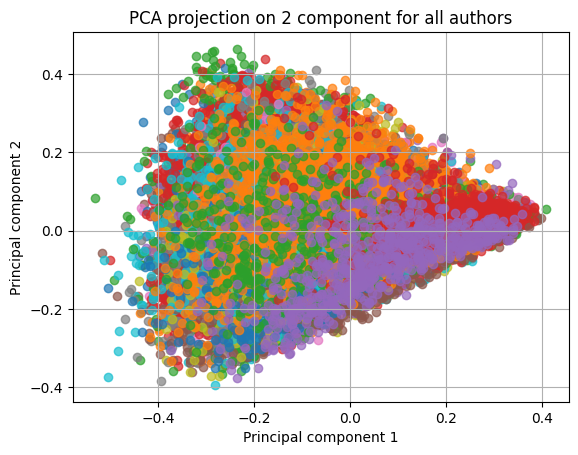

In [16]:
for author in np.unique(y_train):
    mask = y_train == author
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], label=author, alpha=0.7)
plt.title("PCA projection on 2 component for all authors")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.grid()
plt.plot()

Il parait évident que représenter 50 auteurs dans le même plan n'est pas forcément très lisible. De plus, le SVM multi classe fonctionne en "one vs all" pour sa forme de base. Autrement dit, il crée k SVM pour k classes, et il entraîne chaque SVM pour classer un auteur par rapport à tous les autres et procède à un vote majoritaire pour faire la prédiction. Il semble donc cohérent d'essayer d'afficher des projections en "one vs one". Nous allons tirer au hasard 4 fois une paire d'auteurs et les afficher.

*-* For authors 2 and 34
*-* Part of the standard deviation explained by each component : [0.05011073 0.04068511]
*-* Total standard deviation explained : 0.09079584036719301


*-* For authors 43 and 37
*-* Part of the standard deviation explained by each component : [0.05829823 0.0201073 ]
*-* Total standard deviation explained : 0.07840553276274617


*-* For authors 14 and 31
*-* Part of the standard deviation explained by each component : [0.07107071 0.03308086]
*-* Total standard deviation explained : 0.1041515644345668


*-* For authors 18 and 2
*-* Part of the standard deviation explained by each component : [0.06261617 0.02399477]
*-* Total standard deviation explained : 0.08661093660230809




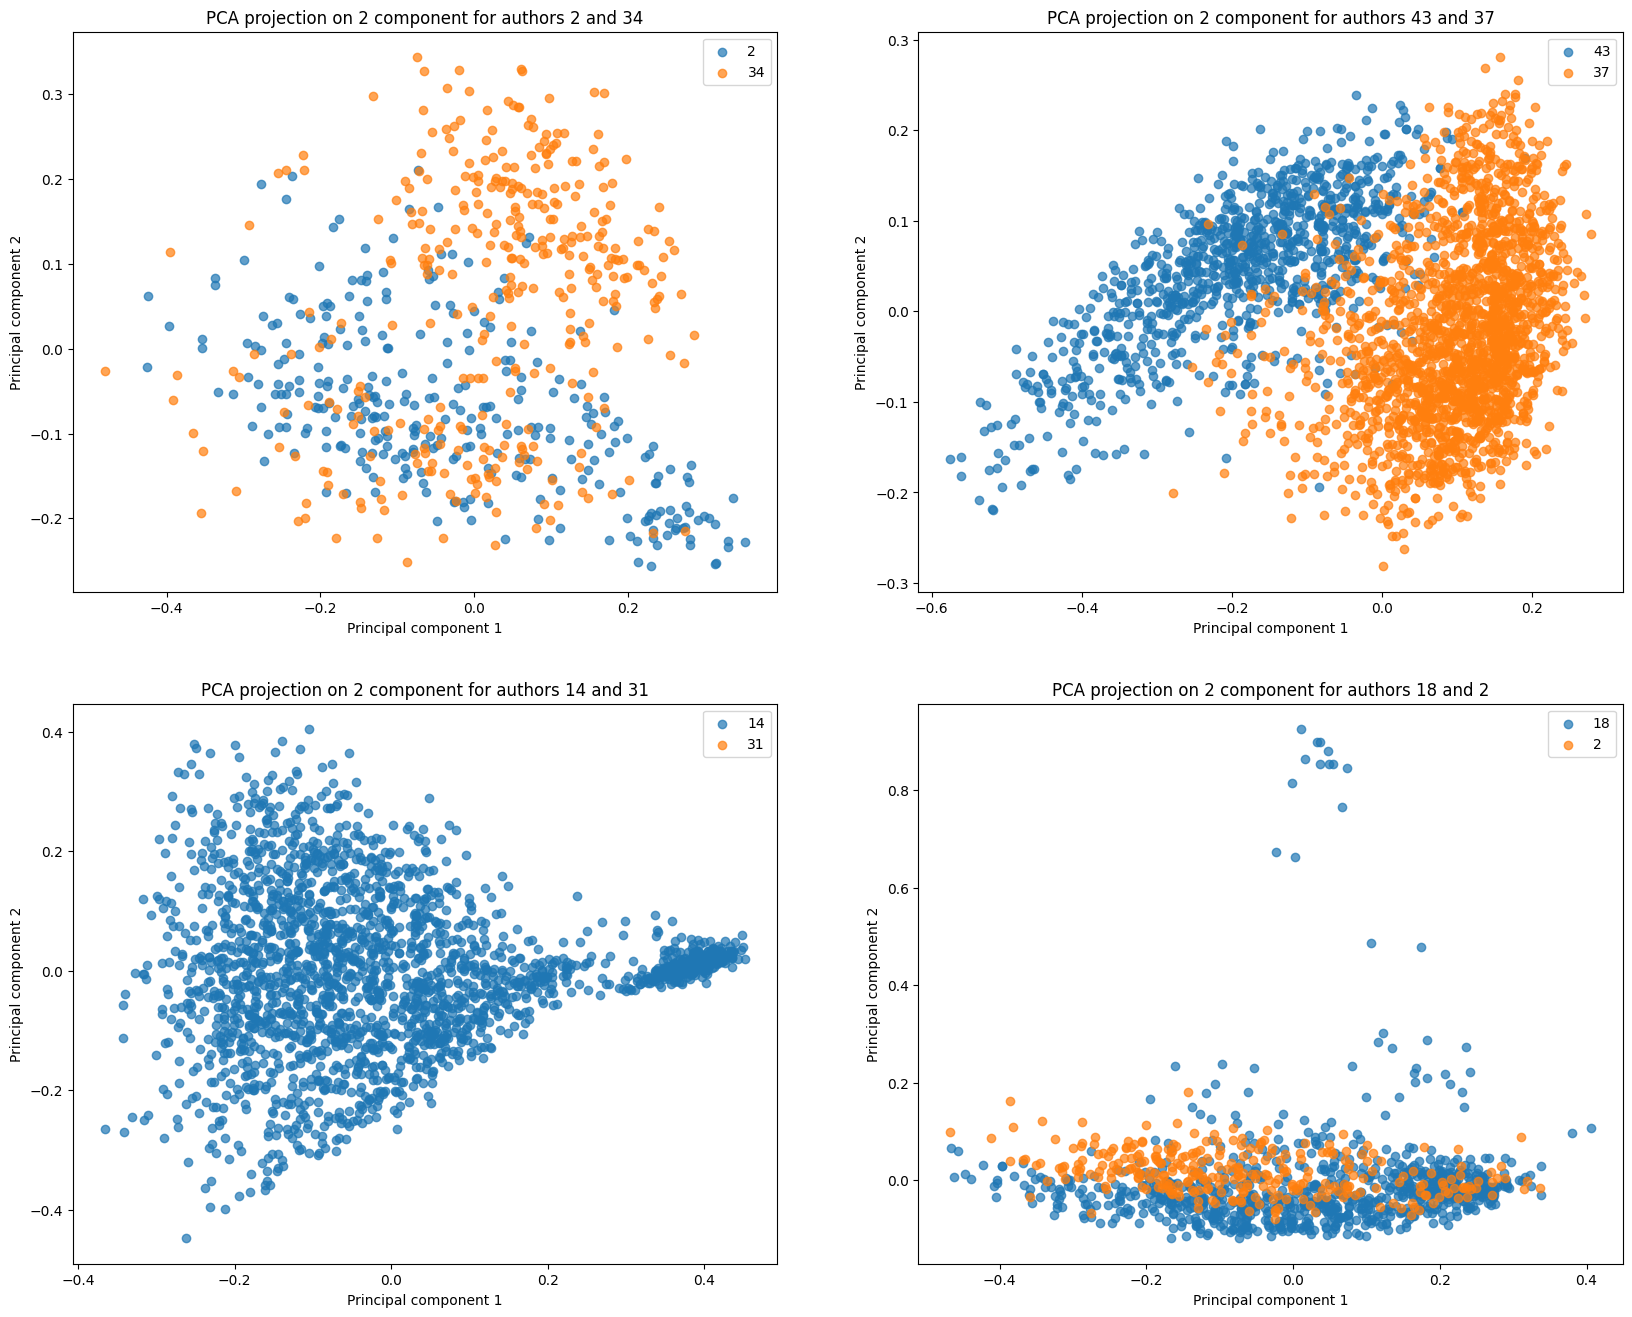

In [20]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(20,16))
axes = axes.flatten()
for i in range(4):
    ax = axes[i]
    i1 = int(random.random() * 50 + 1)
    i2 = int(random.random() * 50 + 1)
    
    pca = PCA(n_components=2, random_state=42) # 2D pca
    y_mask = (y_train == i1) | (y_train == i2)
    X_tmp = X_train_tfidf[y_mask]
    X_train_pca = pca.fit_transform(X_tmp.toarray())
    print(f"*-* For authors {i1} and {i2}")
    print("*-* Part of the standard deviation explained by each component :", pca.explained_variance_ratio_)
    print("*-* Total standard deviation explained :", pca.explained_variance_ratio_.sum())
    print("\n")
    
    authors = [i1, i2]
    for author in authors:
        mask = y_train[y_mask] == author
        ax.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], label=author, alpha=0.7)
    
    ax.set_title(f"PCA projection on 2 component for authors {i1} and {i2}")
    ax.set_xlabel("Principal component 1")
    ax.set_ylabel("Principal component 2")
    ax.legend()
plt.show()

On remarque que la PCA sur 2 composantes permet d'expliquer plus ou moins bien certaines paires. Et à la difference de la représentation avec tous les auteurs, on peut nettement voir la distinction spatiale entre les deux auteurs. On remarque aussi un recouvrement entre les auteurs, ce qui est très normal car ils utilisent tous le même vocabulaire en partie. Leur distinction se fait sur quelques mots comme vu plus haut.